In [13]:
import glob
#import cv2
import itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import *
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import os


NUM_CLASSES = 2
IMG_SIZE = 224


# ***DATA LOADING AND PRE-PROCESSING***

In [14]:
import os
images = []
labels =[]
for sub_dir in os.listdir('Training'):
  image_list=os.listdir(os.path.join('Training',sub_dir))  #list of all image names in the directory
  image_list = list(map(lambda x:os.path.join(sub_dir,x),image_list))
  images.extend(image_list)
  labels.extend([sub_dir]*len(image_list)) 

In [15]:
df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
df_train = df.head(10000)
df_test = df.tail(3000)

In [16]:
train_data = df_train.groupby('Labels').count()
test_data = df_test.groupby('Labels').count()

In [17]:
train_data

,Images
Labels,
fire,760
nofire,760


In [18]:
test_data

,Images
Labels,
fire,760
nofire,760


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=50,
    validation_split=0.3,
    )

In [20]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory='Training',
x_col="Images",
y_col="Labels",
subset='training',
batch_size=16,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory='Training',
x_col="Images",
y_col="Labels",
subset='validation',
batch_size=16,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1064 validated image filenames belonging to 2 classes.
Found 456 validated image filenames belonging to 2 classes.


In [21]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 1.0451866404715127, 1: 0.9585585585585585}

In [23]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization
import keras_tuner as kt
hp = kt.HyperParameters()

C:\Users\shaya\AppData\Local\Temp\ipykernel_10832\2095281555.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


# ***MODEL BUILDING***

In [25]:
# ECA BLOCK
def ECA(x):
    k_size = 3 
    squeeze = tf.reduce_mean(x,(2,3),keepdims=False)
    squeeze = tf.expand_dims(squeeze, axis=1)
    attn = layers.Conv1D(filters=1,
    kernel_size=k_size,
    padding='same',
    kernel_initializer='random_normal',
    use_bias=False)(squeeze)

    attn = tf.expand_dims(tf.transpose(attn, [0, 2, 1]), 3)
    attn = tf.math.sigmoid(attn)
    scale = x * attn
    return x * attn

In [26]:
def resblock(inputs, filters, strides):
    
    y = inputs # Shortcut path
    
    # Main path
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=3,
        strides=strides,
        padding='same',
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=3,
        strides=1,
        padding='same',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Fit shortcut path dimenstions
    if strides > 1:
        y = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=3,
        strides=strides,
        padding='same',
        )(y)
        y = tf.keras.layers.BatchNormalization()(y)

    # Concatenate paths
    x = tf.keras.layers.Add()([x, y])
    x = tf.keras.layers.ReLU()(x)

    return x

# ***HYPER PARAM TUNING***

In [27]:
def build_model(hp):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
    
    for layer in model.layers:
        if layer.name not in ['block7d_project_conv']:
            layer.trainable = False

    # Rebuild top
#     x = tf.keras.layers.ReLU()(model.output)
#     filters_res=hp.Int('Res_filter', min_value=32, max_value=512, step=32)
#     x = resblock(x, filters_res,  2)
#     x = resblock(x, filters_res,  1)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Flatten()(x)
    
    

    
    # ECA-Net

    x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
    x2 = layers.Rescaling(1./255)(x1)
    x3 = layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=32, step=5), kernel_size=(3, 3), activation='relu', 
                      padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
    x4 = ECA(x3)
    x5 = layers.BatchNormalization(axis=-1)(x4)
    x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
    x7 = layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=10), kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x6)
    x8 = ECA(x7)
    x9 = layers.BatchNormalization(axis=-1)(x8)
    x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
    x11 = layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=15), kernel_size=(3, 3), 
                        activation='relu', padding = 'same')(x10)

    x12 = ECA(x11)
    x13 = layers.BatchNormalization(axis=-1)(x12)
    x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
    x15 = layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=128, max_value=256, step=20), kernel_size=(3, 3), 
                          activation='relu', padding = 'same')(x14)
    x16 = ECA(x15)
    x17 = layers.BatchNormalization(axis=-1)(x16)
    x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
    y1 = layers.Flatten()(x18)
    concat = Concatenate()([y1,x])
    dense1  = layers.Dense(units=hp.Int('dense_units_1', min_value=128, max_value=512, step=64), activation='relu')(concat)
    dropout1= Dropout(hp.Float('dropout', 0.25, 0.4, step=0.05))(dense1)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(dropout1)

    # Compile
       
    model = tf.keras.Model(inputs, outputs, name="EfficientAttentioNet")
    model.compile(
         optimizer=keras.optimizers.Adam(
         hp.Choice('learning_rate', values=[1e-4, 1e-5])),
         loss='categorical_crossentropy',
         metrics=['accuracy'])
    
    return model

In [28]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    directory='my_dir',
    project_name='Optimization')

Reloading Tuner from my_dir\Optimization\tuner0.json


In [29]:
tuner.search(train_generator, epochs=5, validation_data=valid_generator,class_weight=train_class_weights)

# Print the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of filter in the first Conv layer: {best_hps.get('conv_1_filter')}")
print(f"Optimal number of filter in the second Conv layer: {best_hps.get('conv_2_filter')}")
print(f"Optimal number of filter in the Third Conv layer: {best_hps.get('conv_3_filter')}")
print(f"Optimal number of filter in the Fourth Conv layer: {best_hps.get('conv_4_filter')}")
print(f"Optimal number of units in the first dense layer: {best_hps.get('dense_units_1')}")
print(f"Optimal number of units in the dropout layer: {best_hps.get('dropout')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of filter in the first Conv layer: 26
Optimal number of filter in the second Conv layer: 52
Optimal number of filter in the Third Conv layer: 79
Optimal number of filter in the Fourth Conv layer: 188
Optimal number of units in the first dense layer: 512
Optimal number of units in the dropout layer: 0.3
Optimal learning rate: 0.0001


In [30]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")

    for layer in model.layers:
        if layer.name not in ['block7d_project_conv']:
            layer.trainable = False

        if layer.trainable:
            print(layer.name)

    # Rebuild top
    x = layers.BatchNormalization()(model.output)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Flatten()(x)
    
    

    
    # ECA-Net

    x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
    x2 = layers.Rescaling(1./255)(x1)
    x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                      padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
    x4 = ECA(x3)
    x5 = layers.BatchNormalization(axis=-1)(x4)
    x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
    x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x6)
    x8 = ECA(x7)
    x9 = layers.BatchNormalization(axis=-1)(x8)
    x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
    x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                        activation='relu', padding = 'same')(x10)

    x12 = ECA(x11)
    x13 = layers.BatchNormalization(axis=-1)(x12)
    x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
    x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                          activation='relu', padding = 'same')(x14)
    x16 = ECA(x15)
    x17 = layers.BatchNormalization(axis=-1)(x16)
    x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
    y1 = layers.Flatten()(x18)
    concat = Concatenate()([y1,x])
    dense1  = layers.Dense(512, activation='relu')(concat)
    dropout1= Dropout(0.4)(dense1)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(dropout1)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientAttentioNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) 
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['Accuracy']
    )
    return model

In [31]:
model = build_model(num_classes=NUM_CLASSES)

block7d_project_conv


In [19]:
model.summary()

Model: "EfficientAttentioNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalizatio

In [20]:
from tensorflow.keras.utils import plot_model 
plot_model(model, to_file="my_model.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 47.0/47.0 kB 138.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install cv2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [32]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['Accuracy'])
    plt.plot(hist.history['val_Accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

In [34]:
epochs = 5
hist = model.fit_generator( generator=train_generator,
                            validation_data=valid_generator,
                            epochs=epochs,
                            class_weight=train_class_weights,
                            callbacks=[callback],
                            verbose=1
)

C:\Users\shaya\AppData\Local\Temp\ipykernel_10832\161382046.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator( generator=train_generator,


Epoch 1/5
67/67 [==============================] - 562s 8s/step - loss: 0.4651 - Accuracy: 0.8449 - val_loss: 0.6904 - val_Accuracy: 0.5504
Epoch 2/5
67/67 [==============================] - 563s 8s/step - loss: 0.2869 - Accuracy: 0.9192 - val_loss: 0.7063 - val_Accuracy: 0.4496
Epoch 3/5
67/67 [==============================] - 555s 8s/step - loss: 0.3293 - Accuracy: 0.8976 - val_loss: 0.6911 - val_Accuracy: 0.5504
Epoch 4/5
67/67 [==============================] - 515s 8s/step - loss: 0.3174 - Accuracy: 0.9164 - val_loss: 0.8965 - val_Accuracy: 0.4496
Epoch 5/5
67/67 [==============================] - 401s 6s/step - loss: 0.2603 - Accuracy: 0.9145 - val_loss: 0.7327 - val_Accuracy: 0.4496


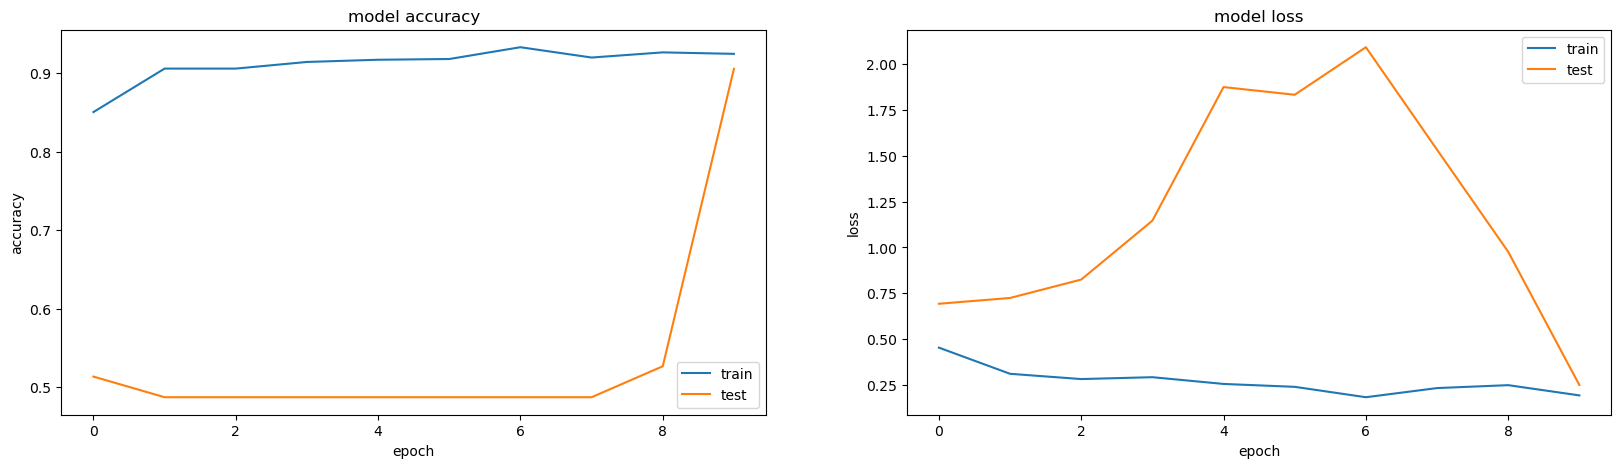

In [25]:
plot_hist(hist)  # took 2h:41m to complete

# ***EVALUATION***

In [35]:
score = model.evaluate(valid_generator, verbose = 0) 
print('Validation loss:', score[0]) 
print('Validation accuracy:', score[1])
accuracy = score[1]

Validation loss: 0.7326204776763916
Validation accuracy: 0.4495614171028137


In [36]:
test_generator=train_datagen.flow_from_dataframe(
dataframe=df_test,
directory='Training',
x_col="Images",
y_col="Labels",
batch_size=16,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 1520 validated image filenames belonging to 2 classes.


In [35]:
test_score = model.evaluate(test_generator, verbose = 0) 
print('Test loss:', test_score[0]) 
print('Test accuracy:', test_score[1])

Test loss: 0.24546366930007935
Test accuracy: 0.9059210419654846


In [36]:
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)
    
print(target_names)

['fire', 'nofire']


# ***MATRICES***

In [37]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

***CONFUSION MATRIX***

Confusion Matrix
Confusion matrix, without normalization


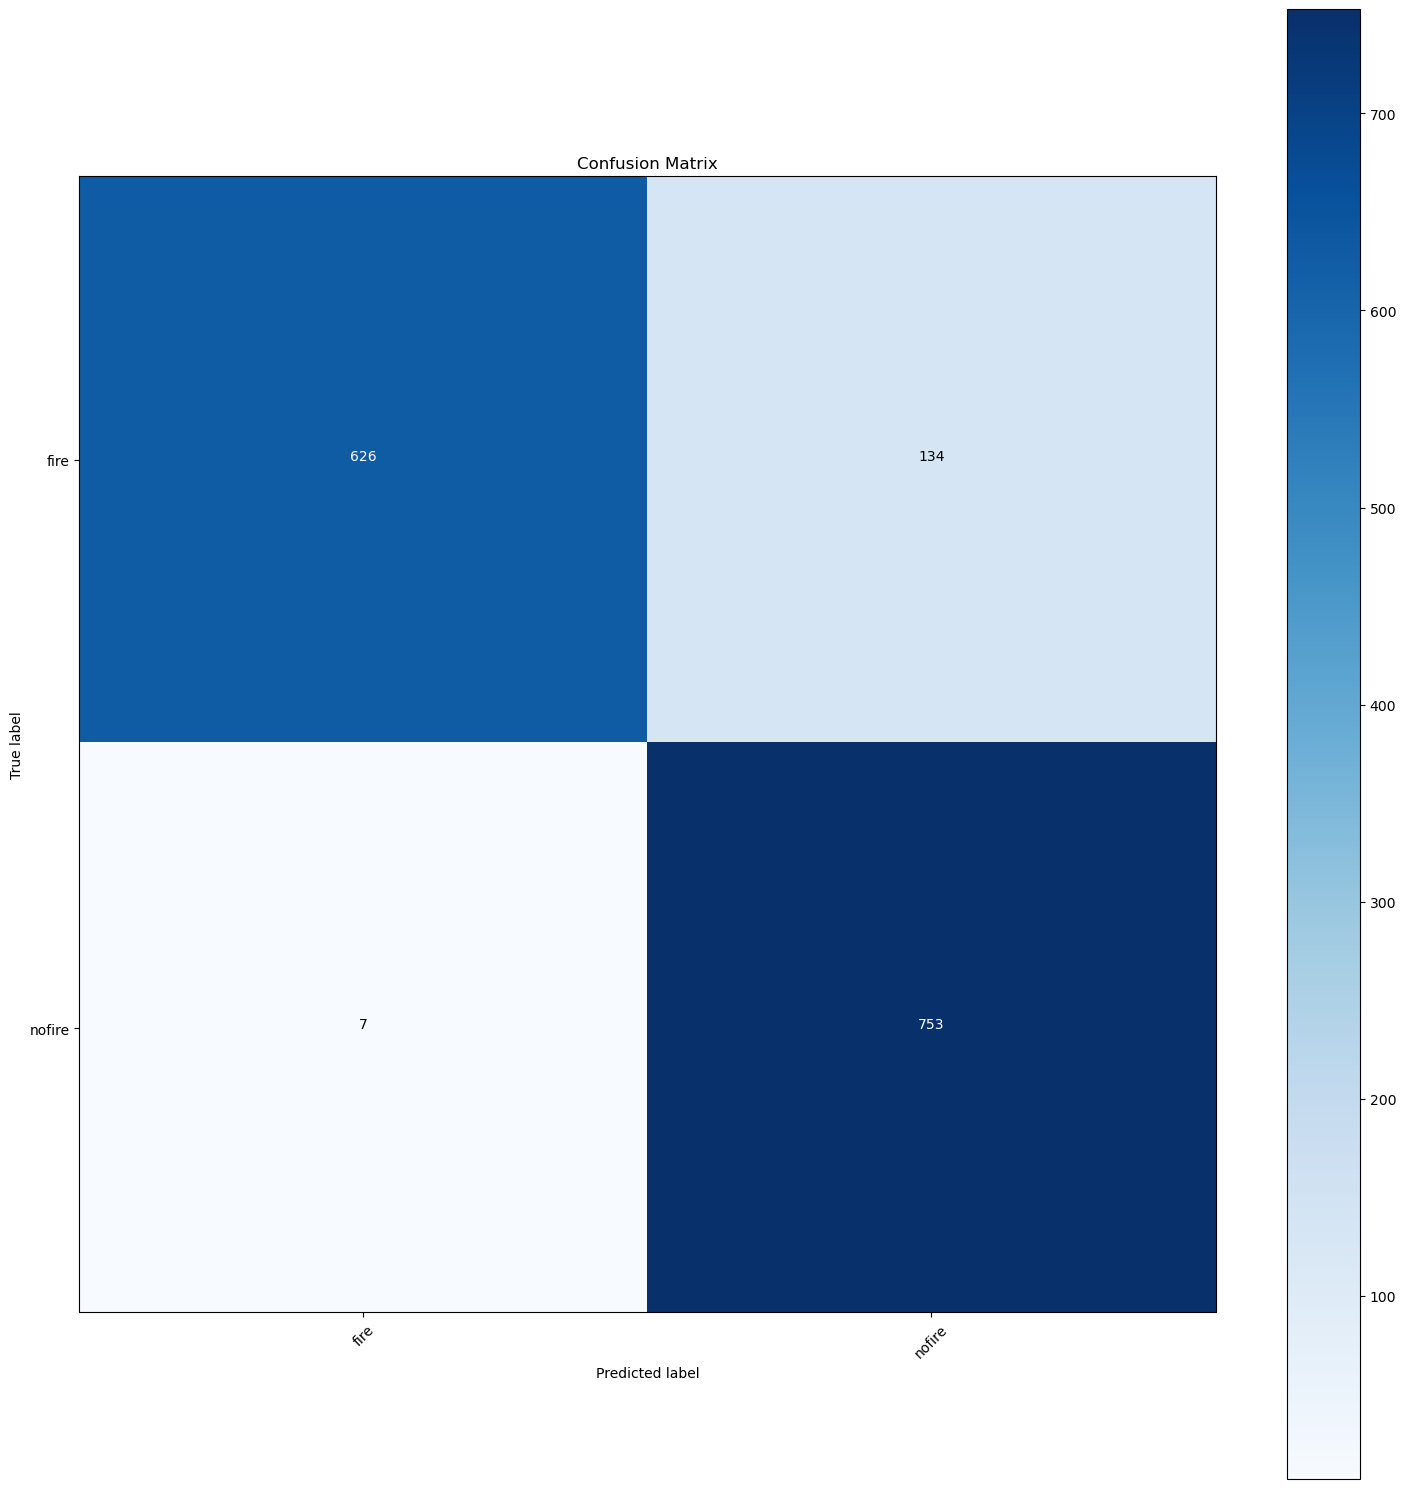

In [39]:
from sklearn.metrics import confusion_matrix,classification_report
# Y_pred = model.predict(x_test,batch_size=16)
Y_pred = model.predict(test_generator,batch_size=16)
y_pred = np.argmax(Y_pred, axis=1)


# labels = np.argmax(y_test,axis=-1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
# cm = confusion_matrix(labels, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', normalize=False)




***CLASSIFICATION REPORT***

In [40]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        fire       0.99      0.82      0.90       760
      nofire       0.85      0.99      0.91       760

    accuracy                           0.91      1520
   macro avg       0.92      0.91      0.91      1520
weighted avg       0.92      0.91      0.91      1520



***ROC-AUC CURVE***

1/1 [==============================] - 12s 12s/step


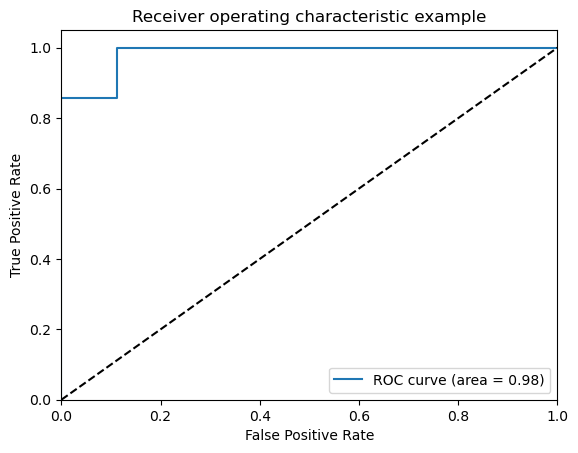

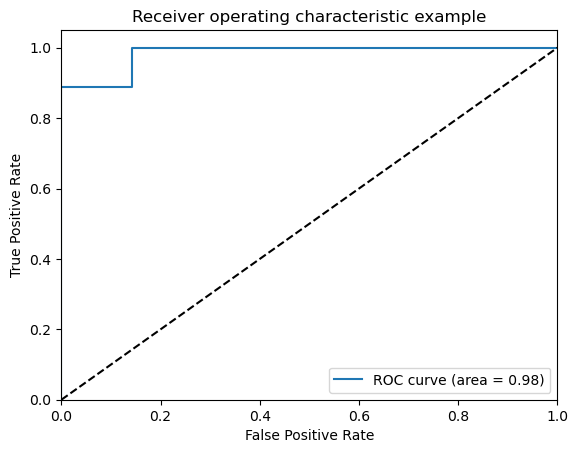

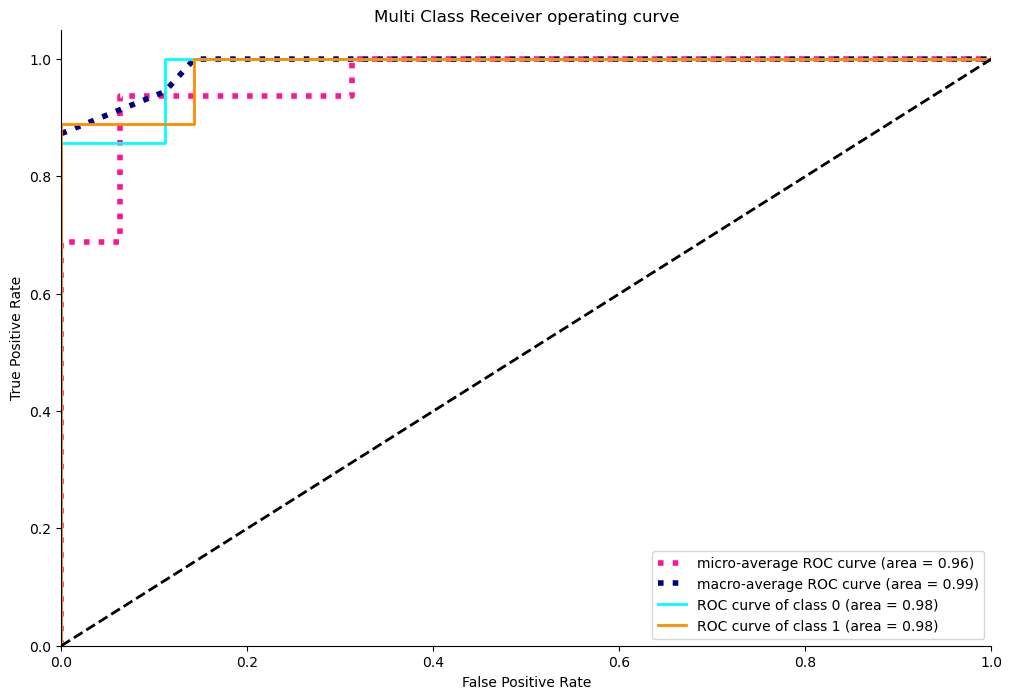

In [41]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


x_test, y_test = next(test_generator)

n_classes = 2

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class Receiver operating curve')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# ***GRAD-CAM***

In [42]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}
filenames = test_generator.filenames

In [43]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = test_generator.classes
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [45]:
val_df.head(10)

,filename,actual,predicted,Same
0,fire\fire_0640.jpg,fire,fire,True
1,nofire\nofire_0569.jpg,nofire,nofire,True
2,nofire\nofire_0731.jpg,nofire,nofire,True
3,fire\fire_0129.jpg,fire,fire,True
4,fire\fire_0543.jpg,fire,fire,True
5,nofire\nofire_0594.jpg,nofire,nofire,True
6,fire\fire_0508.jpg,fire,fire,True
7,fire\fire_0319.jpg,fire,fire,True
8,nofire\nofire_0621.jpg,nofire,nofire,True
9,fire\fire_0147.jpg,fire,fire,True


In [50]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (25 , 25))
    n = 0
    for i in range(3):
        n+=1
        plt.subplot(3 , 3, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"Training/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

In [51]:
from tensorflow.keras.models import Sequential, Model
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model1, pred_index=None):
    
    grad_model = Model(inputs=model1.inputs, outputs=[model1.get_layer("conv2d_15").output, model1.output]) #model1.get_layer("conv2d_4").output #model1.layers[-17].output

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds 

In [53]:
def gradCAMImage(image):
    path = f"Training/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    # superimposed_img = 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [54]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [59]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

ValueError: No such layer: conv2d_15. Existing layers are [<keras.engine.input_layer.InputLayer object at 0x000001DFFBBDFCD0>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001DFFDD33970>, <keras.layers.preprocessing.normalization.Normalization object at 0x000001DFFDD33AC0>, <keras.layers.convolutional.ZeroPadding2D object at 0x000001DFFDD33FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDDA7580>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDDD60D0>, <keras.layers.core.activation.Activation object at 0x000001DFFDDD6E80>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDE72520>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDDD6C70>, <keras.layers.core.activation.Activation object at 0x000001DFFDEAB070>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDEAB730>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDE794F0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDEB3640>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDEBA6D0>, <keras.layers.merge.Multiply object at 0x000001DFFDEBAC70>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDE79AC0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDEC7EE0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDECD6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDEC19A0>, <keras.layers.core.activation.Activation object at 0x000001DFFDED9220>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDED9B50>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDEB3DF0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDEE7400>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDEE7910>, <keras.layers.merge.Multiply object at 0x000001DFFDEEC850>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDEF3580>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDEF7BB0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDEF3BE0>, <keras.layers.merge.Add object at 0x000001DFFDECE910>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDEF3310>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF054C0>, <keras.layers.core.activation.Activation object at 0x000001DFFDF121C0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDF128E0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDF057C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF19D00>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF1E130>, <keras.layers.merge.Multiply object at 0x000001DFFDF26280>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF26EB0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF324F0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDF2D820>, <keras.layers.merge.Add object at 0x000001DFFDF26C70>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDF36BE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF26E20>, <keras.layers.core.activation.Activation object at 0x000001DFFDF36AF0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDF439D0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDF49640>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF2D430>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF4EF40>, <keras.layers.merge.Multiply object at 0x000001DFFDF594F0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF54370>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF59F10>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDF6C0D0>, <keras.layers.merge.Add object at 0x000001DFFDF6C0A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF68E20>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF49820>, <keras.layers.core.activation.Activation object at 0x000001DFFDF19790>, <keras.layers.convolutional.ZeroPadding2D object at 0x000001DFFDF126A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDF59B50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDED4190>, <keras.layers.core.activation.Activation object at 0x000001DFFDF73490>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDF73D30>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDF77610>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF79880>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF7D0D0>, <keras.layers.merge.Multiply object at 0x000001DFFDF7D700>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF89220>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF8F040>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF8F850>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDFAB160>, <keras.layers.core.activation.Activation object at 0x000001DFFDFABF70>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDF8F6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDFB5D30>, <keras.layers.core.activation.Activation object at 0x000001DFFDFB21F0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDFBD8B0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDFC0610>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFC0C70>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFC7F40>, <keras.layers.merge.Multiply object at 0x000001DFFDFD44C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFD0130>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDFDDCD0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDFE70A0>, <keras.layers.merge.Add object at 0x000001DFFDFE7070>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFE3DC0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDFF0C70>, <keras.layers.core.activation.Activation object at 0x000001DFFDFF8430>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDFF8190>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE004400>, <keras.layers.core.activation.Activation object at 0x000001DFFE0090D0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE009820>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE004550>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0160D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0164C0>, <keras.layers.merge.Multiply object at 0x000001DFFDFF8F40>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFD00D0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDFA49D0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDF89F40>, <keras.layers.merge.Add object at 0x000001DFFDFD4E20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF59C10>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF77220>, <keras.layers.core.activation.Activation object at 0x000001DFFE01C4F0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE054130>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE0547F0>, <keras.layers.core.activation.Activation object at 0x000001DFFE0552B0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE0586A0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE058CA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE055220>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE055310>, <keras.layers.merge.Multiply object at 0x000001DFFE059A60>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE052190>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE06C280>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE0713A0>, <keras.layers.merge.Add object at 0x000001DFFE071040>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0557C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE07D220>, <keras.layers.core.activation.Activation object at 0x000001DFFE07D9A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE0767F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE088970>, <keras.layers.core.activation.Activation object at 0x000001DFFE08D460>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE08DD90>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE094190>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE09C640>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE09CA30>, <keras.layers.merge.Multiply object at 0x000001DFFE0AA5E0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0B0190>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE0AAE20>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE0B7F70>, <keras.layers.merge.Add object at 0x000001DFFE0BC5B0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0BC370>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE0C15B0>, <keras.layers.core.activation.Activation object at 0x000001DFFE0CD100>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE0CDBE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE0BCEB0>, <keras.layers.core.activation.Activation object at 0x000001DFFBBA2BE0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDEC74C0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDEBA520>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF32D00>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF05C70>, <keras.layers.merge.Multiply object at 0x000001DFFDEE7E20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFC0C10>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDED4730>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDFB2F70>, <keras.layers.merge.Add object at 0x000001DFFDFD09A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDFB2B50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE07DA90>, <keras.layers.core.activation.Activation object at 0x000001DFFE0A4400>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE09CE80>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE06CA90>, <keras.layers.core.activation.Activation object at 0x000001DFFDF6C6D0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDF73520>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE016670>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDA6B940>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0592E0>, <keras.layers.merge.Multiply object at 0x000001DFFE064A60>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE059670>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDF8F5E0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFDF127C0>, <keras.layers.merge.Add object at 0x000001DFFDFBD550>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE0D27C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE01C3D0>, <keras.layers.core.activation.Activation object at 0x000001DFFE0D2790>, <keras.layers.convolutional.ZeroPadding2D object at 0x000001DFFDF199A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE104970>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE100400>, <keras.layers.core.activation.Activation object at 0x000001DFFE1090D0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE1181C0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE118D00>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE109430>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1206A0>, <keras.layers.merge.Multiply object at 0x000001DFFE0D2310>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE10ED90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE109070>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE136220>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE131FA0>, <keras.layers.core.activation.Activation object at 0x000001DFFE10E160>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFDF8F640>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE0F9460>, <keras.layers.core.activation.Activation object at 0x000001DFFDFC08B0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFDF39CA0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFDFE7340>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDF7D790>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE142070>, <keras.layers.merge.Multiply object at 0x000001DFFE142520>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE13FA30>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE149400>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE1495E0>, <keras.layers.merge.Add object at 0x000001DFFDFE7310>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE13F040>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE159250>, <keras.layers.core.activation.Activation object at 0x000001DFFE1598E0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE153F70>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE166850>, <keras.layers.core.activation.Activation object at 0x000001DFFE15E9D0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE16E3D0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE170130>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE170B50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE17CA90>, <keras.layers.merge.Multiply object at 0x000001DFFE185550>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE180FA0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE18D7F0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE192910>, <keras.layers.merge.Add object at 0x000001DFFE1923D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE197640>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE19E7C0>, <keras.layers.core.activation.Activation object at 0x000001DFFE1A33A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE17CE20>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE1A9F10>, <keras.layers.core.activation.Activation object at 0x000001DFFE1A9D30>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE1B1820>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE1B7850>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1C54F0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1BBD90>, <keras.layers.merge.Multiply object at 0x000001DFFE1A90A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1971C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE1702B0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE197A90>, <keras.layers.merge.Add object at 0x000001DFFE1499D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1CC6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE1CC670>, <keras.layers.core.activation.Activation object at 0x000001DFFE1CD670>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE1D3130>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE1D3820>, <keras.layers.core.activation.Activation object at 0x000001DFFE1D9310>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE1DB6D0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE1DBCD0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1D9790>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1E0A90>, <keras.layers.merge.Multiply object at 0x000001DFFE1E8FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1D9370>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE1F52E0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE1F9400>, <keras.layers.merge.Add object at 0x000001DFFE1F9040>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1F5760>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE205280>, <keras.layers.core.activation.Activation object at 0x000001DFFE200190>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE205E50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE2119D0>, <keras.layers.core.activation.Activation object at 0x000001DFFE2164C0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE216DF0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE21D430>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE2256A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE225A90>, <keras.layers.merge.Multiply object at 0x000001DFFE231640>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE22B6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE2391F0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFE241FD0>, <keras.layers.merge.Add object at 0x000001DFFE244610>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE2416A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE241EB0>, <keras.layers.core.activation.Activation object at 0x000001DFFF225160>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF225C40>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE244D30>, <keras.layers.core.activation.Activation object at 0x000001DFFE21D6A0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFE211190>, <keras.layers.core.reshape.Reshape object at 0x000001DFFE1F54C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE1EE850>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF229670>, <keras.layers.merge.Multiply object at 0x000001DFFF229BE0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF22D820>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF231100>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF22D760>, <keras.layers.merge.Add object at 0x000001DFFF2313A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF236580>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF23DB50>, <keras.layers.core.activation.Activation object at 0x000001DFFF236E80>, <keras.layers.convolutional.ZeroPadding2D object at 0x000001DFFF22DB50>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF246730>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF2351C0>, <keras.layers.core.activation.Activation object at 0x000001DFFF252340>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF254490>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF252BB0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF236DC0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF25C430>, <keras.layers.merge.Multiply object at 0x000001DFFF236E20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2594C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF259A30>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF252880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF274D00>, <keras.layers.core.activation.Activation object at 0x000001DFFF280310>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF259D60>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF286070>, <keras.layers.core.activation.Activation object at 0x000001DFFF28B220>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF291370>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF28B610>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF299850>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF29E3A0>, <keras.layers.merge.Multiply object at 0x000001DFFF29E880>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF299460>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF299730>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF2A6070>, <keras.layers.merge.Add object at 0x000001DFFF286190>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2A0190>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF236700>, <keras.layers.core.activation.Activation object at 0x000001DFFF2316A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF2A0EB0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF2B5700>, <keras.layers.core.activation.Activation object at 0x000001DFFF2B77F0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF2B9280>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF2BFCA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2BF3A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2B9700>, <keras.layers.merge.Multiply object at 0x000001DFFF2CDE50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2D3880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF2D86A0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF2DD7C0>, <keras.layers.merge.Add object at 0x000001DFFF2D3EE0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2C8B50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF2EB640>, <keras.layers.core.activation.Activation object at 0x000001DFFF2EE220>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF2EBA60>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF2F5D90>, <keras.layers.core.activation.Activation object at 0x000001DFFF2FE190>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF2FE910>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF3035B0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF308A60>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF310430>, <keras.layers.merge.Multiply object at 0x000001DFFF319A00>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF320400>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF323430>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF3253D0>, <keras.layers.merge.Add object at 0x000001DFFF325070>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF325850>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF331B50>, <keras.layers.core.activation.Activation object at 0x000001DFFF33A160>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF33A760>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF341A30>, <keras.layers.core.activation.Activation object at 0x000001DFFF348520>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF348E50>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF33A040>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF320E20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF308FD0>, <keras.layers.merge.Multiply object at 0x000001DFFF2EEFA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2B9B20>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFE2398B0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF2B5910>, <keras.layers.merge.Add object at 0x000001DFFF34E9D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF34A880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3256A0>, <keras.layers.core.activation.Activation object at 0x000001DFFF34A790>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF2DD2E0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF359F70>, <keras.layers.core.activation.Activation object at 0x000001DFFF35E220>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF35ED60>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF3667C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF366EE0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF36E4F0>, <keras.layers.merge.Multiply object at 0x000001DFFF35E8E0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF36E2B0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3801C0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF384520>, <keras.layers.merge.Add object at 0x000001DFFF384220>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF37C340>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF393190>, <keras.layers.core.activation.Activation object at 0x000001DFFF37C7F0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF38D6D0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF39E8E0>, <keras.layers.core.activation.Activation object at 0x000001DFFF3A43D0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF3A4D00>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF3AC100>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3B35B0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3B39A0>, <keras.layers.merge.Multiply object at 0x000001DFFF3C1550>, <keras.layers.convolutional.Conv2D object at 0x000001DFFE244430>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3C1DF0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF3CF160>, <keras.layers.merge.Add object at 0x000001DFFF3CAA00>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF2E4880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF25C6A0>, <keras.layers.core.activation.Activation object at 0x000001DFFF3B3850>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF3983D0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3B3C70>, <keras.layers.core.activation.Activation object at 0x000001DFFE1CCD30>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF3C8FA0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF36E6A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF356340>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3CAC70>, <keras.layers.merge.Multiply object at 0x000001DFFF3594C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3DD400>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3DAC40>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF3E7550>, <keras.layers.merge.Add object at 0x000001DFFF3DA580>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3CAE50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3F2F40>, <keras.layers.core.activation.Activation object at 0x000001DFFF3DDC10>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF3F21C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3845B0>, <keras.layers.core.activation.Activation object at 0x000001DFFF3E75B0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF3DD250>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF4086D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF40E700>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3E3E20>, <keras.layers.merge.Multiply object at 0x000001DFFF40EBE0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF40E9A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF4110A0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF424E50>, <keras.layers.merge.Add object at 0x000001DFFF40ED90>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3F2130>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF4243D0>, <keras.layers.core.activation.Activation object at 0x000001DFFF4112E0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF4382B0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF400160>, <keras.layers.core.activation.Activation object at 0x000001DFFF424E20>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF41E7F0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF3FBFD0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF44A340>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF441220>, <keras.layers.merge.Multiply object at 0x000001DFFF44AE50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF41E160>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF42DDC0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF3E73A0>, <keras.layers.merge.Add object at 0x000001DFFF4536A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3E3880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF37C1F0>, <keras.layers.core.activation.Activation object at 0x000001DFFF44B5E0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF35E970>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF461F10>, <keras.layers.core.activation.Activation object at 0x000001DFFF453640>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF44BFA0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF438E20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF46DA60>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF393D00>, <keras.layers.merge.Multiply object at 0x000001DFFF4740D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF47C7C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF47C100>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4677F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF482EE0>, <keras.layers.core.activation.Activation object at 0x000001DFFF474C40>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF4810A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF498C70>, <keras.layers.core.activation.Activation object at 0x000001DFFF492970>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF47C2E0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF4617C0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4A8A60>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4A8490>, <keras.layers.merge.Multiply object at 0x000001DFFF4B1F70>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4B87C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF4B8100>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF4CF880>, <keras.layers.merge.Add object at 0x000001DFFF4B16A0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4C7730>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF4DE340>, <keras.layers.core.activation.Activation object at 0x000001DFFF4B80A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF4C7AF0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF498850>, <keras.layers.core.activation.Activation object at 0x000001DFFF4C7970>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF4B8280>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF4E9A90>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4F4CA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4D63A0>, <keras.layers.merge.Multiply object at 0x000001DFFF4F4A30>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4C2850>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF49B7F0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF474C70>, <keras.layers.merge.Add object at 0x000001DFFF4F4190>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF3EF250>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF3845E0>, <keras.layers.core.activation.Activation object at 0x000001DFFF4E9E50>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF4D5490>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF4E4520>, <keras.layers.core.activation.Activation object at 0x000001DFFF492790>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF4DEAF0>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF4E4460>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF506520>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF504700>, <keras.layers.merge.Multiply object at 0x000001DFFF506400>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF5147C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF504670>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF525850>, <keras.layers.merge.Add object at 0x000001DFFF50B880>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF4FE2B0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF50BC10>, <keras.layers.core.activation.Activation object at 0x000001DFFF514880>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF5222E0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF536430>, <keras.layers.core.activation.Activation object at 0x000001DFFF519C10>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF519100>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF543310>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF543B20>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF522A00>, <keras.layers.merge.Multiply object at 0x000001DFFF543820>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF552C70>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF5524F0>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF568C70>, <keras.layers.merge.Add object at 0x000001DFFF54AB50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF562730>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF5737F0>, <keras.layers.core.activation.Activation object at 0x000001DFFF573880>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF562C70>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF580A60>, <keras.layers.core.activation.Activation object at 0x000001DFFF580580>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF57D280>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF580F40>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF525790>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF5302B0>, <keras.layers.merge.Multiply object at 0x000001DFFF504B50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF504B80>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF530220>, <keras.layers.core.dropout.Dropout object at 0x000001DFFF58DA90>, <keras.layers.merge.Add object at 0x000001DFFF53C3D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF56D9A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF58A7C0>, <keras.layers.core.activation.Activation object at 0x000001DFFF562D30>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFF5986A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFF57D9D0>, <keras.layers.core.activation.Activation object at 0x000001DFFF58A760>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DFFF4FEA90>, <keras.layers.core.reshape.Reshape object at 0x000001DFFF57D910>, <keras.layers.convolutional.Conv2D object at 0x000001DF8124E850>, <keras.layers.convolutional.Conv2D object at 0x000001DF8124B670>, <keras.layers.merge.Multiply object at 0x000001DF8125F9D0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF573580>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8125FFD0>, <keras.layers.core.dropout.Dropout object at 0x000001DF8126AA60>, <keras.layers.merge.Add object at 0x000001DF8124EA90>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF5953A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8125FDC0>, <keras.layers.core.activation.Activation object at 0x000001DF812589D0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81279EB0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81279640>, <keras.layers.core.activation.Activation object at 0x000001DF8124E9A0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF8125F310>, <keras.layers.core.reshape.Reshape object at 0x000001DF81285520>, <keras.layers.convolutional.Conv2D object at 0x000001DF812851F0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8128D220>, <keras.layers.merge.Multiply object at 0x000001DF8128D160>, <keras.layers.convolutional.Conv2D object at 0x000001DF8128CE50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8128C700>, <keras.layers.core.dropout.Dropout object at 0x000001DF812A9E80>, <keras.layers.merge.Add object at 0x000001DF8128DD60>, <keras.layers.convolutional.Conv2D object at 0x000001DF8124B0A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812B5A00>, <keras.layers.core.activation.Activation object at 0x000001DF8129B700>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF812A16D0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8126F5E0>, <keras.layers.core.activation.Activation object at 0x000001DF81279D60>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF8129BF40>, <keras.layers.core.reshape.Reshape object at 0x000001DF8126ACD0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF58AD90>, <keras.layers.convolutional.Conv2D object at 0x000001DF8128C6D0>, <keras.layers.merge.Multiply object at 0x000001DF812C0FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DFFF50BA90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812C0A30>, <keras.layers.core.dropout.Dropout object at 0x000001DF812C53A0>, <keras.layers.merge.Add object at 0x000001DFFF525DF0>, <keras.layers.convolutional.Conv2D object at 0x000001DF812B0BB0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812CB8B0>, <keras.layers.core.activation.Activation object at 0x000001DF812B7160>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF812D15B0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8128DD90>, <keras.layers.core.activation.Activation object at 0x000001DF812C5490>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF812B7AF0>, <keras.layers.core.reshape.Reshape object at 0x000001DF8128DC40>, <keras.layers.convolutional.Conv2D object at 0x000001DF812EFFA0>, <keras.layers.convolutional.Conv2D object at 0x000001DF812D9B50>, <keras.layers.merge.Multiply object at 0x000001DF812F8AF0>, <keras.layers.convolutional.Conv2D object at 0x000001DF812B7460>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812FDF70>, <keras.layers.core.dropout.Dropout object at 0x000001DF812EFF10>, <keras.layers.merge.Add object at 0x000001DF812EF9A0>, <keras.layers.convolutional.Conv2D object at 0x000001DF812D72B0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812FDD00>, <keras.layers.core.activation.Activation object at 0x000001DF812F89A0>, <keras.layers.convolutional.ZeroPadding2D object at 0x000001DF812D90A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DFFE120820>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81318B20>, <keras.layers.core.activation.Activation object at 0x000001DF812EFA30>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF812FD220>, <keras.layers.core.reshape.Reshape object at 0x000001DF81329C70>, <keras.layers.convolutional.Conv2D object at 0x000001DF81329FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81307730>, <keras.layers.merge.Multiply object at 0x000001DF813301C0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8134DCD0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81345EE0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8134DD90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81318B50>, <keras.layers.core.activation.Activation object at 0x000001DF8133E880>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81330B80>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF812C0E50>, <keras.layers.core.activation.Activation object at 0x000001DF8133E5B0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF813452B0>, <keras.layers.core.reshape.Reshape object at 0x000001DF81356190>, <keras.layers.convolutional.Conv2D object at 0x000001DF813591F0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81330F10>, <keras.layers.merge.Multiply object at 0x000001DF813591C0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81359430>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8135C1C0>, <keras.layers.core.dropout.Dropout object at 0x000001DF8136E1F0>, <keras.layers.merge.Add object at 0x000001DF81359820>, <keras.layers.convolutional.Conv2D object at 0x000001DF812D92E0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8136EBB0>, <keras.layers.core.activation.Activation object at 0x000001DF8135C5B0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81372A90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81360CD0>, <keras.layers.core.activation.Activation object at 0x000001DF81367A00>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81360280>, <keras.layers.core.reshape.Reshape object at 0x000001DF81345FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DF814CBBE0>, <keras.layers.convolutional.Conv2D object at 0x000001DF814C67F0>, <keras.layers.merge.Multiply object at 0x000001DF814CB790>, <keras.layers.convolutional.Conv2D object at 0x000001DF8135C220>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF814C6C40>, <keras.layers.core.dropout.Dropout object at 0x000001DF814E8310>, <keras.layers.merge.Add object at 0x000001DF814D0130>, <keras.layers.convolutional.Conv2D object at 0x000001DF814C64F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF814D04F0>, <keras.layers.core.activation.Activation object at 0x000001DF814DB130>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF814EE3A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF814F5CA0>, <keras.layers.core.activation.Activation object at 0x000001DF814E14C0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF814DB970>, <keras.layers.core.reshape.Reshape object at 0x000001DF81509250>, <keras.layers.convolutional.Conv2D object at 0x000001DF815097C0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81519910>, <keras.layers.merge.Multiply object at 0x000001DF81510F10>, <keras.layers.convolutional.Conv2D object at 0x000001DF814DB2E0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF814C6940>, <keras.layers.core.dropout.Dropout object at 0x000001DF81360940>, <keras.layers.merge.Add object at 0x000001DF81510400>, <keras.layers.convolutional.Conv2D object at 0x000001DF814E8D90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81509D90>, <keras.layers.core.activation.Activation object at 0x000001DF815198B0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF8135C640>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF814F5AC0>, <keras.layers.core.activation.Activation object at 0x000001DF814E81C0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81519430>, <keras.layers.core.reshape.Reshape object at 0x000001DF81529940>, <keras.layers.convolutional.Conv2D object at 0x000001DF8152EB50>, <keras.layers.convolutional.Conv2D object at 0x000001DF8152B2B0>, <keras.layers.merge.Multiply object at 0x000001DF8152ED90>, <keras.layers.convolutional.Conv2D object at 0x000001DF8152EBE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8152E9A0>, <keras.layers.core.dropout.Dropout object at 0x000001DF81540F70>, <keras.layers.merge.Add object at 0x000001DF8152E0D0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8135C6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81540640>, <keras.layers.core.activation.Activation object at 0x000001DF815390A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81554520>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815263D0>, <keras.layers.core.activation.Activation object at 0x000001DF81540760>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81539A60>, <keras.layers.core.reshape.Reshape object at 0x000001DF81526310>, <keras.layers.convolutional.Conv2D object at 0x000001DF815675B0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81567EB0>, <keras.layers.merge.Multiply object at 0x000001DF81575A60>, <keras.layers.convolutional.Conv2D object at 0x000001DF8155FBE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8156D820>, <keras.layers.core.dropout.Dropout object at 0x000001DF815878E0>, <keras.layers.merge.Add object at 0x000001DF8156D910>, <keras.layers.convolutional.Conv2D object at 0x000001DF81553220>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8157AC70>, <keras.layers.core.activation.Activation object at 0x000001DF81575910>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81567370>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815974C0>, <keras.layers.core.activation.Activation object at 0x000001DF815A4340>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF815A45E0>, <keras.layers.core.reshape.Reshape object at 0x000001DF815A43A0>, <keras.layers.convolutional.Conv2D object at 0x000001DF815A4FD0>, <keras.layers.convolutional.Conv2D object at 0x000001DF815826A0>, <keras.layers.merge.Multiply object at 0x000001DF8154CE80>, <keras.layers.convolutional.Conv2D object at 0x000001DF8157AAC0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8155FEB0>, <keras.layers.core.dropout.Dropout object at 0x000001DF8152BDC0>, <keras.layers.merge.Add object at 0x000001DF81597A90>, <keras.layers.convolutional.Conv2D object at 0x000001DF81567730>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815B4D60>, <keras.layers.core.activation.Activation object at 0x000001DF8152E7C0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF815B2F70>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8158FB80>, <keras.layers.core.activation.Activation object at 0x000001DF81378430>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF815750D0>, <keras.layers.core.reshape.Reshape object at 0x000001DF815C54F0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8155FEE0>, <keras.layers.convolutional.Conv2D object at 0x000001DF815B2DC0>, <keras.layers.merge.Multiply object at 0x000001DF815CEE50>, <keras.layers.convolutional.Conv2D object at 0x000001DF815CABE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815CA850>, <keras.layers.core.dropout.Dropout object at 0x000001DF815E7130>, <keras.layers.merge.Add object at 0x000001DF815CABB0>, <keras.layers.convolutional.Conv2D object at 0x000001DF815B2F10>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815E01F0>, <keras.layers.core.activation.Activation object at 0x000001DF815CE0A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF815E8E20>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815B8F40>, <keras.layers.core.activation.Activation object at 0x000001DF815E0D90>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF815DA610>, <keras.layers.core.reshape.Reshape object at 0x000001DF815B8E50>, <keras.layers.convolutional.Conv2D object at 0x000001DF81E73160>, <keras.layers.convolutional.Conv2D object at 0x000001DF81E71A60>, <keras.layers.merge.Multiply object at 0x000001DF81E73DF0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81E88400>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81E81580>, <keras.layers.core.dropout.Dropout object at 0x000001DF81E99490>, <keras.layers.merge.Add object at 0x000001DF815F4E50>, <keras.layers.convolutional.Conv2D object at 0x000001DF815E8D90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81E81370>, <keras.layers.core.activation.Activation object at 0x000001DF81EA7220>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81EA7B50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EA7070>, <keras.layers.core.activation.Activation object at 0x000001DF815E0100>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81E88D00>, <keras.layers.core.reshape.Reshape object at 0x000001DF815CAA00>, <keras.layers.convolutional.Conv2D object at 0x000001DF815BF490>, <keras.layers.convolutional.Conv2D object at 0x000001DF81E99D60>, <keras.layers.merge.Multiply object at 0x000001DF815E81F0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81EB0670>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF815B2040>, <keras.layers.core.dropout.Dropout object at 0x000001DF81EB76D0>, <keras.layers.merge.Add object at 0x000001DF815C5130>, <keras.layers.convolutional.Conv2D object at 0x000001DF81E95220>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EC52B0>, <keras.layers.core.activation.Activation object at 0x000001DF81EB0490>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81ECD1F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81E9E040>, <keras.layers.core.activation.Activation object at 0x000001DF81EB7820>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81EB0BB0>, <keras.layers.core.reshape.Reshape object at 0x000001DF81ED6940>, <keras.layers.convolutional.Conv2D object at 0x000001DF81EE3B50>, <keras.layers.convolutional.Conv2D object at 0x000001DF81EDF2B0>, <keras.layers.merge.Multiply object at 0x000001DF81EE3D90>, <keras.layers.convolutional.Conv2D object at 0x000001DF81EE3BE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EE39A0>, <keras.layers.core.dropout.Dropout object at 0x000001DF81EF5F70>, <keras.layers.merge.Add object at 0x000001DF81EE30D0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81EC53A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EF5640>, <keras.layers.core.activation.Activation object at 0x000001DF81EEE0D0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81F0B520>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81ED23D0>, <keras.layers.core.activation.Activation object at 0x000001DF81EF5760>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81EEEA60>, <keras.layers.core.reshape.Reshape object at 0x000001DF81ED2310>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F185B0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F18EB0>, <keras.layers.merge.Multiply object at 0x000001DF81F2AA60>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F15BE0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81F23820>, <keras.layers.core.dropout.Dropout object at 0x000001DF81F3D8E0>, <keras.layers.merge.Add object at 0x000001DF81F23910>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F3D7F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81F003D0>, <keras.layers.core.activation.Activation object at 0x000001DF81ED2850>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81F15E80>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EE3B80>, <keras.layers.core.activation.Activation object at 0x000001DF81F239A0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81F2E190>, <keras.layers.core.reshape.Reshape object at 0x000001DF81F0B250>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F449D0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F39580>, <keras.layers.merge.Multiply object at 0x000001DF81F44340>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F47C40>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81F4A340>, <keras.layers.core.dropout.Dropout object at 0x000001DF81F63B80>, <keras.layers.merge.Add object at 0x000001DF81F479A0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F5CCD0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81F6C640>, <keras.layers.core.activation.Activation object at 0x000001DF81F47F40>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81F68880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF81EF5C10>, <keras.layers.core.activation.Activation object at 0x000001DF81F5C880>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF81F4A3D0>, <keras.layers.core.reshape.Reshape object at 0x000001DF831DBD90>, <keras.layers.convolutional.Conv2D object at 0x000001DF831D7D30>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F68AC0>, <keras.layers.merge.Multiply object at 0x000001DF831E9C40>, <keras.layers.convolutional.Conv2D object at 0x000001DF831E9D30>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF831E9DF0>, <keras.layers.convolutional.Conv2D object at 0x000001DF81F68C10>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF831F99D0>, <keras.layers.core.activation.Activation object at 0x000001DF831F3370>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF831FFBB0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8320EDC0>, <keras.layers.core.activation.Activation object at 0x000001DF831FFEB0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF831F3FD0>, <keras.layers.core.reshape.Reshape object at 0x000001DF83219F70>, <keras.layers.preprocessing.image_preprocessing.Resizing object at 0x000001DFFAF8AC10>, <keras.layers.convolutional.Conv2D object at 0x000001DF83227FD0>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001DFFAE84FA0>, <keras.layers.convolutional.Conv2D object at 0x000001DF831E9490>, <keras.layers.convolutional.Conv2D object at 0x000001DF83247D90>, <keras.layers.merge.Multiply object at 0x000001DF83227340>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834E4C10>, <keras.layers.convolutional.Conv2D object at 0x000001DF8322A940>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834E4E80>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8322A820>, <keras.layers.convolutional.Conv1D object at 0x000001DF8325D790>, <keras.layers.core.dropout.Dropout object at 0x000001DF83219550>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF81F6CFA0>, <keras.layers.merge.Add object at 0x000001DF832276A0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF8321BA30>, <keras.layers.convolutional.Conv2D object at 0x000001DF831F97C0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF8325D6A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF831E20A0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834E80A0>, <keras.layers.core.activation.Activation object at 0x000001DF83233610>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF832476A0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF81F2A310>, <keras.layers.pooling.MaxPooling2D object at 0x000001DFFDD83610>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF831FF310>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDD83070>, <keras.layers.core.activation.Activation object at 0x000001DF8322A9A0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834E88B0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF8322A1F0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DFFDD837C0>, <keras.layers.core.reshape.Reshape object at 0x000001DF832406D0>, <keras.layers.convolutional.Conv1D object at 0x000001DF8324BEE0>, <keras.layers.convolutional.Conv2D object at 0x000001DF8321B6D0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834F6C70>, <keras.layers.convolutional.Conv2D object at 0x000001DF831DB3D0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834F6940>, <keras.layers.merge.Multiply object at 0x000001DF8321B5E0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834EF280>, <keras.layers.convolutional.Conv2D object at 0x000001DF831DBCA0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834FE850>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF83256970>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF834DF340>, <keras.layers.core.dropout.Dropout object at 0x000001DF832628B0>, <keras.layers.pooling.MaxPooling2D object at 0x000001DF834E8730>, <keras.layers.merge.Add object at 0x000001DF8321BC40>, <keras.layers.convolutional.Conv2D object at 0x000001DF834FE100>, <keras.layers.convolutional.Conv2D object at 0x000001DF831DBA90>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FDA0D0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF83256700>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FDA730>, <keras.layers.core.activation.Activation object at 0x000001DF832503A0>, <keras.layers.convolutional.Conv1D object at 0x000001DF834EF1C0>, <keras.layers.convolutional.DepthwiseConv2D object at 0x000001DF8324BD90>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FE01C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF83270490>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834FE430>, <keras.layers.core.activation.Activation object at 0x000001DF8324B910>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF834FE4F0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF83250BE0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FE0AC0>, <keras.layers.core.reshape.Reshape object at 0x000001DF83280370>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFDD8D130>, <keras.layers.convolutional.Conv2D object at 0x000001DF83280BE0>, <keras.layers.pooling.MaxPooling2D object at 0x000001DF80FEF250>, <keras.layers.convolutional.Conv2D object at 0x000001DF8325D460>, <keras.layers.convolutional.Conv2D object at 0x000001DF834F6250>, <keras.layers.merge.Multiply object at 0x000001DF832806D0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FEF310>, <keras.layers.convolutional.Conv2D object at 0x000001DF83289D90>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FE8FD0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF83289610>, <keras.layers.convolutional.Conv1D object at 0x000001DF8325D820>, <keras.layers.core.dropout.Dropout object at 0x000001DF832A1E50>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FF66D0>, <keras.layers.merge.Add object at 0x000001DF83285C70>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FE8B50>, <keras.layers.convolutional.Conv2D object at 0x000001DFFDE725E0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF80FE0B50>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF832AE9D0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001DF8100C1F0>, <keras.layers.core.activation.Activation object at 0x000001DF83293610>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DF8100C7C0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DFFD87CC70>, <keras.layers.pooling.MaxPooling2D object at 0x000001DF8100C940>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF83295E50>, <keras.layers.core.flatten.Flatten object at 0x000001DF80FEFAF0>, <keras.layers.core.flatten.Flatten object at 0x000001DF8325D640>, <keras.layers.merge.Concatenate object at 0x000001DF8325D280>, <keras.layers.core.dense.Dense object at 0x000001DFFAFCAD00>, <keras.layers.core.dropout.Dropout object at 0x000001DF81015580>, <keras.layers.core.dense.Dense object at 0x000001DF81018310>].

In [56]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (25 ,25))
    n = 0
    for i in range(3):
        n+=1
        plt.subplot(3 ,3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
#         plt.imshow(val_df[val_df['Same']==True])
    plt.show()

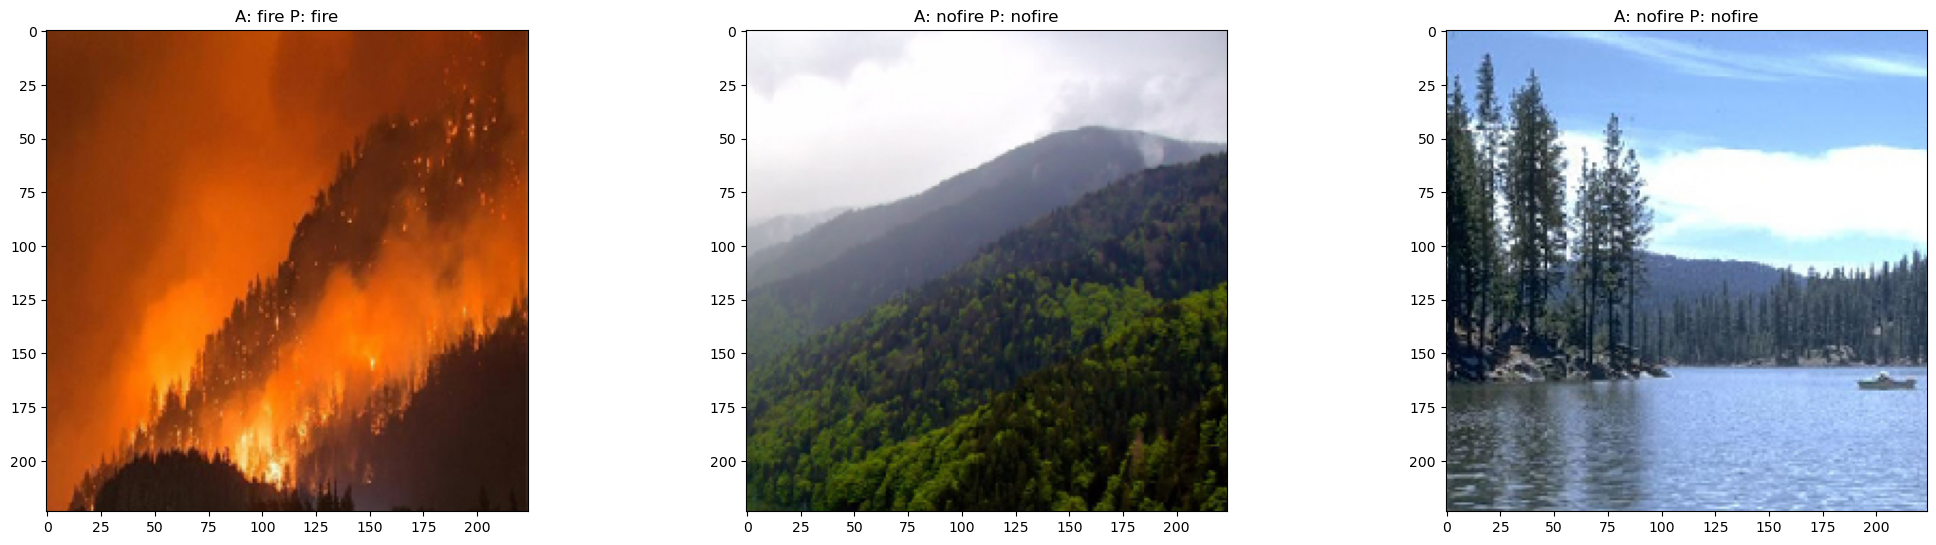

In [57]:
display_images(val_df[val_df['Same']==True])

In [58]:
display_heatmaps(correctly_classified,c_titles)

NameError: name 'correctly_classified' is not defined

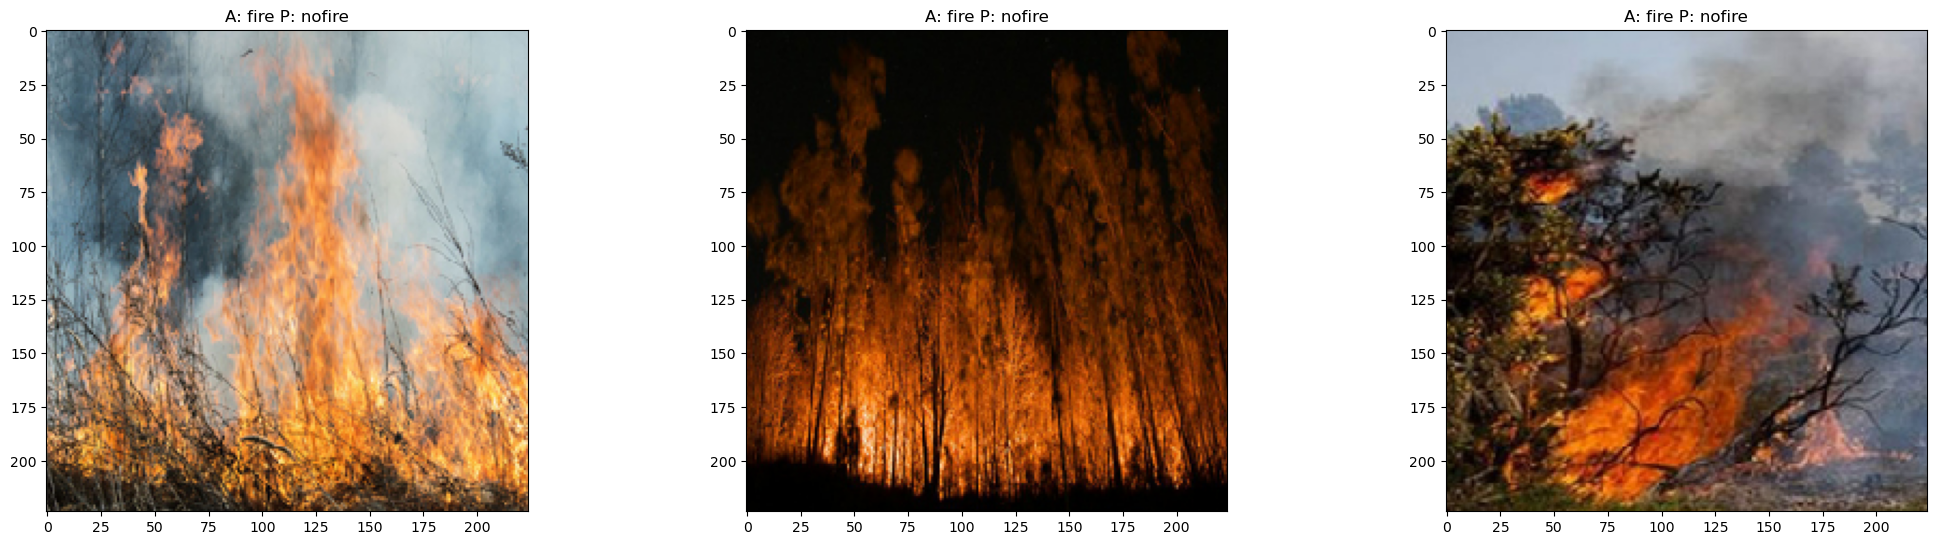

In [60]:
display_images(val_df[val_df['Same']!=True])

In [61]:
display_heatmaps(misclassified,m_titles)

NameError: name 'misclassified' is not defined

# ***LIME***

In [ ]:
pip install lime

In [ ]:
pip install scikit-image

In [ ]:
import lime
import lime.lime_tabular
import skimage
import numpy as np

In [ ]:
from skimage import io
from tensorflow.keras.preprocessing import image

# url = '/kaggle/input/flamedataset/train/Fire/resized_frame0.jpg'
# url = '/kaggle/input/flamedataset/train/Fire/resized_frame11264.jpg'
url = '/kaggle/input/flamedataset/train/Fire/resized_frame7045.jpg'

def read_and_transform_img(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (224,224))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = read_and_transform_img(url)

In [ ]:
# LIME has one explainer for all the models
from lime import lime_image
explainer = lime_image.LimeImageExplainer(random_state=42)

In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1/2+0.5, mask_1))
ax2.imshow(mark_boundaries(temp_2/2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.title("Test Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(url)
plt.imshow(image)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Define CAM class
class CAM:
    def __init__(self, model, last_conv_layer_name):
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name
        self.grad_model = tf.keras.models.Model([self.model.inputs], [self.model.get_layer(self.last_conv_layer_name).output, self.model.output])
        
    def compute_heatmap(self, image):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.grad_model(image)
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]
            
        output = conv_output[0]
        grads = tape.gradient(loss, conv_output)[0]
        weights = tf.reduce_mean(grads, axis=(0, 1))
        heatmap = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

# Load input image
image = cv2.imread('/kaggle/input/flamedataset/train/Fire/resized_frame7045.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)


# Define CAM model
cam_model = CAM(model, 'conv2d_15')

# Compute heatmap
heatmap = cam_model.compute_heatmap(image)

# Rescale heatmap to the range [0, 255]
heatmap = heatmap * 255.0
heatmap = cv2.resize(heatmap, (224, 224))

# Apply colormap to heatmap
heatmap = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_JET)

# Overlay heatmap on input image
result = heatmap * 0.5 + image[0] * 0.5
result = tf.keras.preprocessing.image.array_to_img(result)

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.title("Test Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

plt.imshow(result)
plt.show()

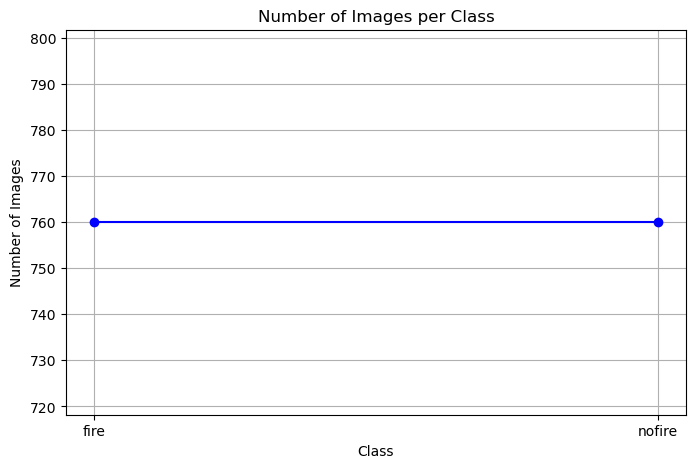

In [1]:
classes = ['fire', 'nofire']
image_counts = [760, 760]

plt.figure(figsize=(8, 5))
plt.plot(classes, image_counts, marker='o', color='b', linestyle='-')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')

plt.grid(True)
plt.show()


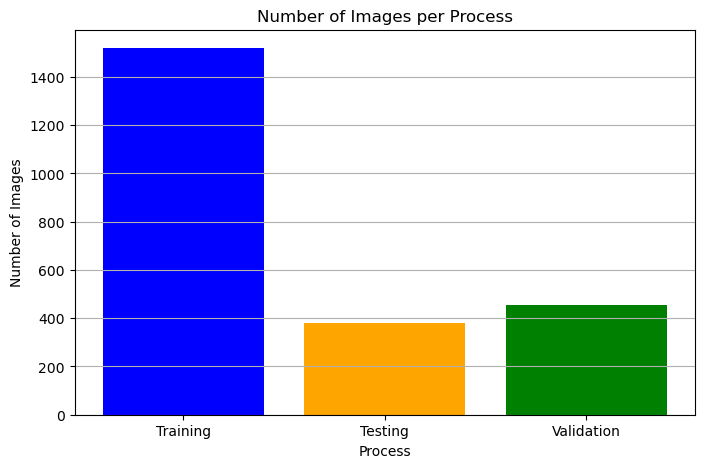

In [2]:
processes = ['Training', 'Testing', 'Validation']
image_counts = [1520, 380, 456]

plt.figure(figsize=(8, 5))
plt.bar(processes, image_counts, color=['blue', 'orange', 'green'])

plt.xlabel('Process')
plt.ylabel('Number of Images')
plt.title('Number of Images per Process')

plt.grid(axis='y')
plt.show()


In [3]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pyswarms.single.global_best import GlobalBestPSO

In [51]:
!pip install pyswarm

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4465 sha256=4686dd0b164685baa1d3131c885f71811ddf5ca58eae9e5db2d57a7073f5a0c8
  Stored in directory: c:\users\shaya\appdata\local\pip\cache\wheels\ff\d2\b7\80118e5698de2bd0b8d1b3397abf7fdfc45c15ffc454b52145
Successfully built pyswarm


In [49]:
model = load_model('newmodel.h5')

In [42]:
def callaccuracy():
    return accuracy

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso

# Define file paths for data
# data_dir = "C:/Users/gulraiz/Desktop/archive - Copy"

# # Define the classes
# classes = ["glioma", "meningioma", "notumor", "pituitary"]

# # Create ImageDataGenerator for data augmentation and normalization
# datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.3)

# # Load and split the data into training, validation, and testing sets
# train_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=(224, 224),
#     classes=classes,
#     batch_size=32,
#     shuffle=True,
#     subset='training'
# )
# val_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=(224, 224),
#     classes=classes,
#     batch_size=32,
#     shuffle=True,
#     subset='validation'
# )

# Create VGG19 model with pre-trained weights
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add custom head to the base model
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(len(classes), activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define objective function for PSO
def objective_function(x):
    # Set the hyperparameters based on the particle values
    learning_rate = x[0]
    num_epochs = math.ceil(x[1])

    # Train the model with the updated hyperparameters
#     model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, verbose=0)

    # Obtain the accuracy on the validation set
    _, val_acc = model.evaluate(valid_generator)

    # Return the negative accuracy to maximize it in PSO
    return -val_acc

# Set the bounds for the hyperparameters
lower_bounds = [0.001, 2]  # Lower bounds for learning_rate and num_epochs
upper_bounds = [0.01, 3]  # Upper bounds for learning_rate and num_epochs

# Perform PSO optimization
best_solution, best_fitness = pso(objective_function, lower_bounds, upper_bounds)

# Print the best solution and its fitness
print("Best Solution (Learning Rate, Num Epochs):", best_solution)
print("Best Fitness (Validation Accuracy):", -best_fitness)

# Train the model with the best hyperparameters
best_num_epochs = math.ceil(best_solution[1])
model.fit(train_generator, validation_data=valid_generator, epochs=best_num_epochs)

# Evaluate the model on the validation set
val_generator.reset()
val_pred_labels = np.argmax(model.predict(valid_generator), axis=1)
val_true_labels = val_generator.classes

# Calculate classification report and confusion matrix
report = classification_report(val_true_labels, val_pred_labels, target_names=classes)
confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)

# Plot training and validation confusion matrices with heatmaps
plt.imshow(confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)

 4/29 [===>..........................] - ETA: 1:31 - loss: 0.4098 - accuracy: 0.8438

KeyboardInterrupt: 